## Sentiment Analysis


In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
from scipy import stats
from pandas.plotting import scatter_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import Word

plot_size = plt.rcParams["figure.figsize"]  

plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AlexanderPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AlexanderPC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\AlexanderPC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)

In [4]:
ira_data.insert(4, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

In [5]:
ira_data.head(10)

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,AD_TARGETING_CUSTOM_AUDIENCE,...,AD_TARGETING_GENDER,AD_TARGETING_INTERESTS,AD_TARGETING_LANGUAGE,AD_TARGETING_LOCATION,AD_TARGETING_LOCATION_LIVING_IN,AD_TARGETING_LOCATION_RECENTLY_IN,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET
AD_ID,,,,,,,,,,,,,,,,,,,,,
1,6.0,2015-10-25 06:28:33,2015-10-27 23:59:00,358.0,0.016760,https://www.instagram.com/us_daily/,2015-q4/2015-10/P(1)0001736.pdf,161.23 RUB,18 - 51,NaN,...,NaN,"News broadcasting, Political party, Breaking n...",English (US),NaN,United States,NaN,NaN,Instagram Feed,Instgogogo,52000000.0
2,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,17256.0,0.002202,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,NaN,...,NaN,NaN,NaN,NaN,United States: Texas,NaN,NaN,Instagram Feed,You can go to hell or follow @south_lone_star ...,115000000.0
3,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,NaN,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,NaN,...,NaN,Cop Block or Black (Color),English (US),NaN,United States,NaN,NaN,Instagram Feed,Black lives matter because we see what's going...,17000000.0
4,33.0,2016-04-19 07:49:45,NaT,14311.0,0.002306,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,NaN,...,NaN,Cop Block,English (US),United States,NaN,NaN,NaN,Instagram Feed,Don't Shoot is a community site where you can ...,490000.0
5,201.0,2016-06-15 03:39:52,NaT,29786.0,0.006748,https://www.facebook.com/govspending-165176135...,2016-q2/2016-06/P(1)0000001.pdf,3714.15 RUB,18 - 65+,NaN,...,NaN,Understanding racial segregation in the united...,NaN,NaN,United States: Georgia,NaN,NaN,Instagram Feed,WHERE is your VOICE?,NaN
6,NaN,2016-05-12 04:06:17,NaT,NaN,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,NaN,...,NaN,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0
7,54.0,2016-05-13 01:18:08,NaT,23408.0,0.002307,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,NaN,...,NaN,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0
8,43.0,2016-03-11 05:04:42,NaT,9559.0,0.004498,https://www.instagram.com/black—america—today/,2016-q1/2016-03/P(1)0006379.pdf,2003.01 RUB,13 - 35,NaN,...,NaN,Hoodies or Trayvon Martin,English (UK)or English (US),United States,NaN,NaN,NaN,Instagram Feed,Trayvon Martin's lawyers wearing hoodies. Wear...,18000.0
9,13.0,2015-11-24 05:34:21,NaT,4871.0,0.002669,https://www.instagram.com/veterans_us/,2015-q4/2015-11/P(1)0001229.pdf,1052.89 RUB,18 - 65+,NaN,...,NaN,"Veterans Day, American Revolutionary War or Pa...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Edward was a combat engineer in Afghanistan wh...,3600000.0


### Extract Hashtags
Extracting the Hashtags in case they are needed later

In [6]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", str(i))
        hashtags.append(ht)

    return hashtags

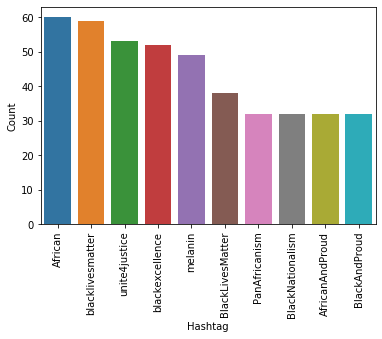

In [7]:
HT = hashtag_extract(ira_data['AD_TEXT'])
HT = sum(HT,[])

a = nltk.FreqDist(HT)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
#d.plot.bar()
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Add column with word count

In [8]:
ira_data['WORD_COUNT'] = ira_data['AD_TEXT'].apply(lambda x: len(str(x).split(" ")))
ira_data = ira_data[ira_data['WORD_COUNT'] > 4]

### Remove hyperlinks

In [9]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')

### Removal of stopwords

In [10]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
ira_data['AD_CLEANED_TEXT']=ira_data['AD_TEXT']
ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

AD_ID
2       You go hell follow @south_lone_star instead! T...
3       Black lives matter see what's going on. We car...
4       Don't Shoot community site find recent videos ...
6       Conservative Christians. Pro-life/ gun/ police...
7       Conservative Christians. Pro-life/ gun/ police...
8       Trayvon Martin's lawyers wearing hoodies. Wear...
9       Edward combat engineer Afghanistan whose job c...
10      Unbelievable amount US government's waste. Joi...
11      Veterans Day coming! There many ways show supp...
12      It's time us understand deserve best. It's tim...
13      The original Statue Liberty France black. The ...
14      This military campaign ambiguous given cost ne...
15      And would choose u president: create 11200 mil...
16      A Wounded Warrior service dog. Support Veteran...
17      What know PTSD? There greater agony. PTSD affe...
18      What know PTSD? There greater agony. PTSD affe...
19      Who save children? Click Learn more! The US Go...
20      

### Removal of words with less than 5 characters

In [11]:
# ira_data['AD_TEXT'] = ira_data['AD_TEXT'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>4]))

### Stemming
removal of suffices, like “ing”, “ly”, “s”, etc. 

In [12]:
st = PorterStemmer()
ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

AD_ID
2       you can go to hell or follow @south_lone_star ...
3       black live matter becaus we see what' go on. W...
4       don't shoot is a commun site where you can fin...
6       conserv christians. pro-life/ gun/ police/ mil...
7       conserv christians. pro-life/ gun/ police/ mil...
8       trayvon martin' lawyer wear hoodies. wear hood...
9       edward wa a combat engin in afghanistan whose ...
10      unbeliev amount of the US government' waste. j...
11      veteran day is coming! there are so mani way t...
12      it' time for us to understand that we do deser...
13      the origin statu of liberti in franc is black....
14      thi militari campaign is veri ambigu given tha...
15      and what would you choos if u were a president...
16      A wound warrior and hi servic dog. support our...
17      what do you know about ptsd? there is no great...
18      what do you know about ptsd? there is no great...
19      who will save the children? click learn more! ...
20      

### Lemmatization
converts the word into its root word

In [13]:
ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))

AD_ID
2       You can go to hell or follow @south_lone_star ...
3       Black life matter because we see what's going ...
4       Don't Shoot is a community site where you can ...
6       Conservative Christians. Pro-life/ gun/ police...
7       Conservative Christians. Pro-life/ gun/ police...
8       Trayvon Martin's lawyer wearing hoodies. Weari...
9       Edward wa a combat engineer in Afghanistan who...
10      Unbelievable amount of the US government's was...
11      Veterans Day is coming! There are so many way ...
12      It's time for u to understand that we do deser...
13      The original Statue of Liberty in France is bl...
14      This military campaign is very ambiguous given...
15      And what would you choose if u were a presiden...
16      A Wounded Warrior and his service dog. Support...
17      What do you know about PTSD? There is no great...
18      What do you know about PTSD? There is no great...
19      Who will save the children? Click Learn more! ...
20      

### Lowercase

In [14]:
ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].str.replace('[^\w\s]','')
ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].str.replace("[^a-zA-Z#]", " ")

In [15]:
ira_data['AD_CLEANED_TEXT'] = ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

### Common word removal
Removes the 10 most common words

In [16]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[:10]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

### Rare words removal
Removes the 10 most uncommon words

In [17]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[-10:]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [18]:
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(x).split())

### Spelling correction
check for ur etc. before correction

In [19]:
# ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(TextBlob(x).correct()))

## Sentiment Analysis with TextBlob

In [20]:
ira_data['AD_TextBlob_POLARITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[0] )
ira_data['AD_TextBlob_SUBJECTIVITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[1] )

In [21]:
ira_data['AD_TextBlob_Sentiment'] = ira_data['AD_TextBlob_POLARITY'].apply(lambda x: 'positive' if x>0 else ('neutral' if x == 0 else 'negative'))

In [22]:
ira_data.head()

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,AD_TARGETING_CUSTOM_AUDIENCE,...,AD_TARGETING_LOCATION_RECENTLY_IN,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET,WORD_COUNT,AD_CLEANED_TEXT,AD_TextBlob_POLARITY,AD_TextBlob_SUBJECTIVITY,AD_TextBlob_Sentiment
AD_ID,,,,,,,,,,,,,,,,,,,,,
2,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,17256.0,0.002202,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,NaN,...,NaN,NaN,Instagram Feed,You can go to hell or follow @south_lone_star ...,115000000.0,37,you can go to hell or follow south lone star i...,0.000000,0.000000,neutral
3,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,NaN,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,NaN,...,NaN,NaN,Instagram Feed,Black lives matter because we see what's going...,17000000.0,43,black lives matter because we see whats going ...,-0.166667,0.433333,negative
4,33.0,2016-04-19 07:49:45,NaT,14311.0,0.002306,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,NaN,...,NaN,NaN,Instagram Feed,Don't Shoot is a community site where you can ...,490000.0,38,dont shoot is a community site where you can f...,-0.075000,0.487500,negative
6,NaN,2016-05-12 04:06:17,NaT,NaN,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,NaN,...,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,7,conservative christians prolife gun police mil...,-0.100000,0.100000,negative
7,54.0,2016-05-13 01:18:08,NaT,23408.0,0.002307,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,NaN,...,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,7,conservative christians prolife gun police mil...,-0.100000,0.100000,negative


Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using TextBlob')

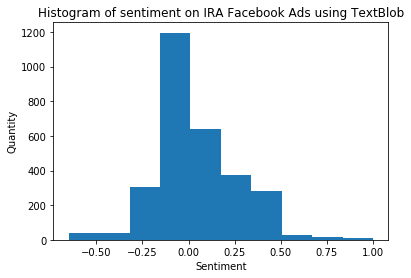

In [23]:
polarity=ira_data[ira_data['AD_TextBlob_SUBJECTIVITY'] < 0.8]
plt.hist(polarity['AD_TextBlob_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Quantity')
plt.title('Histogram of sentiment on IRA Facebook Ads using TextBlob')

Text(0.5, 1.0, 'Histogram of subjectivity on IRA Facebook Ads')

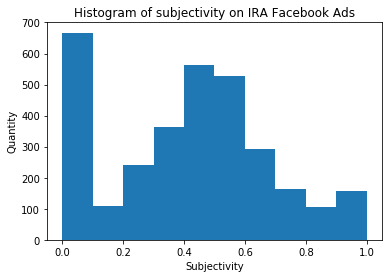

In [24]:
plt.hist(ira_data['AD_TextBlob_SUBJECTIVITY'])
plt.xlabel('Subjectivity')
plt.ylabel('Quantity')
plt.title('Histogram of subjectivity on IRA Facebook Ads')

## Sentiment Analysis with VADER

In [25]:
analyzer = sid()
ira_data['AD_VADER_POLARITY']=ira_data['AD_TEXT'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
ira_data['AD_VADER_Sentiment'] = ira_data['AD_VADER_POLARITY'].apply(lambda x: 'positive' if x>=0.5 else ('negative' if x <= -0.5 else 'neutral'))
ira_data['AD_VADER_Sentiment'].value_counts()

positive    1162
neutral     1160
negative     871
Name: AD_VADER_Sentiment, dtype: int64

Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using VADER')

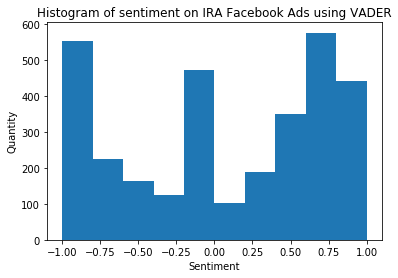

In [26]:
plt.hist(ira_data['AD_VADER_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Quantity')
plt.title('Histogram of sentiment on IRA Facebook Ads using VADER')

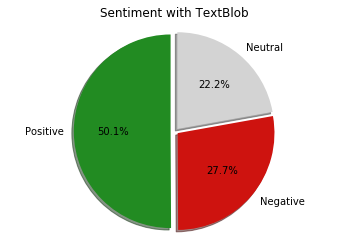

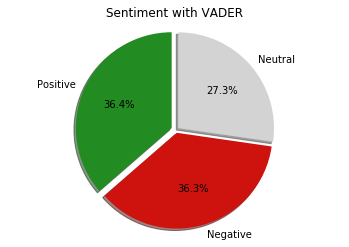

In [27]:
# TODO Change colour of pos and neg so that they are the same

fig1, ax1 = plt.subplots()
explode = (0.05, 0.03, 0.03)
labels='Positive', 'Negative', 'Neutral'
colors=['forestgreen', '#CE130F', 'lightgrey']
ax1.pie(ira_data['AD_TextBlob_Sentiment'].value_counts(), labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal') 
plt.title('Sentiment with TextBlob')
fig2, ax2 = plt.subplots()
ax2.pie(ira_data['AD_VADER_Sentiment'].value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax2.axis('equal') 
plt.title('Sentiment with VADER')

plt.show()

* * * * * * * * * *


### Most Common words

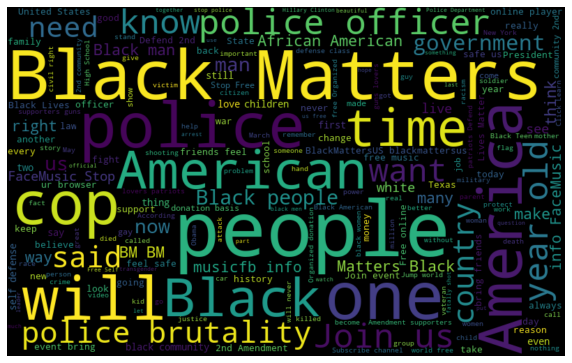

In [28]:
all_words = ' '.join([text for text in ira_data['AD_TEXT']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Most Common words in positive Ads

In [29]:
ira_data = ira_data[ira_data['AD_TextBlob_Sentiment']==ira_data['AD_VADER_Sentiment']]

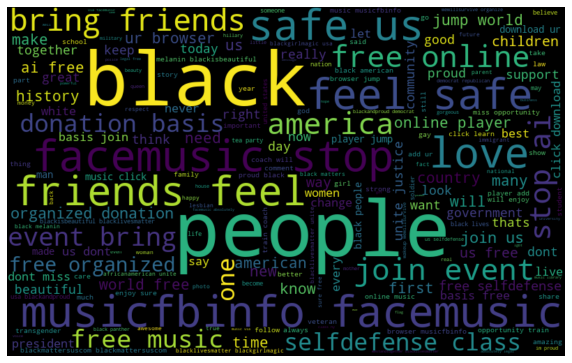

In [30]:
pos_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_VADER_Sentiment'] =="positive"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Most Common words in negative Ads

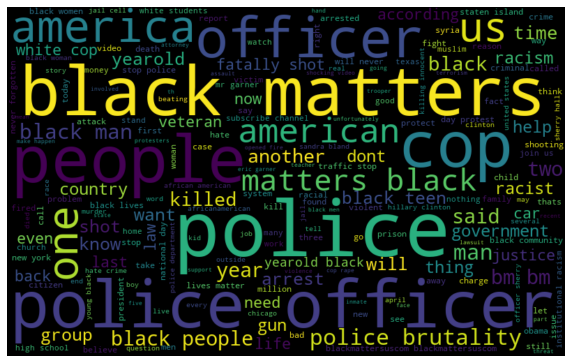

In [31]:
neg_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_VADER_Sentiment'] =="negative"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [32]:
pd.set_option('display.max_colwidth', -1)
ira_data[ira_data['AD_VADER_Sentiment'] == "negative"][['AD_TEXT', 'AD_TextBlob_POLARITY', 'AD_VADER_POLARITY']].sample(25)

,AD_TEXT,AD_TextBlob_POLARITY,AD_VADER_POLARITY
AD_ID,,,
409,"Cornel West on Obama:""The First Black President Has Become The First Niggerized Black President"" Reacting to President Obama's use of the n-word on Marc Maron's podcast, Cornel West called him the first ""niggerized"" president in an appearance on CNN. West criticized Obama as ""a person who is afraid and intimidated when it comes to putting a spotlight on white supremacy."" ""A niggerized black person is a black person who is afraid and scared and intimidated when it comes to putting a spotlight on white supremacy and fighting against white supremacy,"" West explained. ""So when many of us said we have to fight against racism, what were we told?'No, he can't deal with racism because he has other issues, political calculations. He's the president of all America, not just black America.' We know he's president of all America but white supremacy is American as cherry pie."" West is right as usual. African minorities would choose Mr. West in 2009 and 2012 instead of Obama. But we had no choice. Cornel is a good leader, he knows what black community is suffering from. Obama was promoted by big corporations owned by white people. Obama never tried to protect blacks from police pressure, never tried to stop police violence against blacks. Just count how many black lives were destroyed during his presidency. The number is horrific.",-0.035927,-0.9850
2183,"Do you think that there is a place for racism in lawmaking? The answer seems to be obvious but white Alabama legislator, Lynn Greer, of Rogersville would disagree with you. Black lawmakers accuse their colleague of being racist and trying to minimize their influence. Black Lawmakers Enraged By Racist Email I BlackMattersUS.com blackmattersus.com",-0.083333,-0.9741
134,"Black, white, Asian. Hispanic, it doesn't matter. Racism is racism, it's wrong regardless.",-0.166667,-0.6098
3050,"This is the story about 19-year-old Juwan Alexander Plummer. On April 14 the Plummers' door had been kicked in by burglars. On April 16 Plummer, his mother, and his 14-year-old little brother did not see the police lights because the unit was parked down the road. Plummer called 911 to report the burglars and then grabbed his Grandfather's shotgun that was given to his mother for protection. When Plummer went to the door, the scared kid fired a warning shot to fend off the would-be burglars. However, the shotgun blast hit one officer in the arm and the other in the face. Subscribe to our channel:",-0.156019,-0.8360
427,"Police Charges Black Student For Driving To A Well-lit Area Last time I checked US wasn't involved in any wars or anti-terrorist operations, at least officially. Well, then how come Detroit is no less dangerous then (the city ranks third in the list of top 100 US most dangerous cities)?? When 24-year-old DaJuawn Wallace saw flashing blue police lights in his rearview mirror he chose to proceed with caution since some people are known to be robbed by fake police officers. He preferred to find a well-lit area to pull over in. As a result, he was charged with 'fleeing' police. People are terrified by the police to such a degree that they even prefer to communicate with officers only in the well-lit areas. And get charged for that. Sometimes it makes me actually think that when not involved in any military operations in the foreign countries, our country's at war with its own citizens with the help of police.",-0.041667,-0.9677
2451,"If you also think that there should only be peace, come with us and let's make it happen. Stop war! Stop killing the innocent! Some believed Trump would withdraw the U.S. from useless and bloody military campaigns. But what we see is only the enhancement of hostility. We don't need wars no more! We want peace! It's time for politicians to take care of the U.S. residents instead of fating them, as well as other nationals, to death. We're organizing a peaceful gathering to draw public attention to the

In [33]:
ira_data[ira_data['AD_VADER_Sentiment'] == "positive"][['AD_TEXT', 'AD_TextBlob_POLARITY', 'AD_VADER_POLARITY']].sample(25)

,AD_TEXT,AD_TextBlob_POLARITY,AD_VADER_POLARITY
AD_ID,,,
3407,"Free online player! Jump in the world of free music! Click and download for ur browser Unlimited, free and rapid app for you - listen music online on ur Facebook! musicfb.info FaceMusic Stop A.I.",0.400000,0.8617
3160,"Sometimes it takes just a simple gesture, an act of sharing and giving, simply because you have more than enough. Bravo to this selfless Chap, He makes some of us smile with adoration. Bless this Brother #melaninqueen #dope #beautiful #wakeup #wewillsurvive #organize #westandtogether #blacklivesmatter #unite4justice #black #melanin #blackisbeautiful #blacklivesmatter #blackgirlmagic #USA #blackandproud #democrat #republican #Africanamerican #unite4justice #breakingnews #goals #woke",0.211905,0.9246
651,"Nature chooses who will be transgender; individuals don't choose this We received a letter ... the history of life ... «Hello! Just wanted to see if you could share my coming out as trans story on your page. I have been on a long, rough journey to this point and I think my story could help younger trans youth see that no matter how bad it gets it always gets better. I would really appreciate this because I want to become someone who inspires the LGBT community to be themselves! Ever since I was little, I knew I was different. I wasn't like any of the other kids. I had a unique way of thinking and often that left me isolated. Something I still feel the sting of today. Unlike most boys who played with Spiderman and Superman action figures when they were little, I played with barbies ... I wanted to look like them. I wanted to be them. It felt right playing with these dolls. I had to hide when I did it though because even at an early age, I knew boys weren't supposed to play with dolls. Once I had gotten got caught by my grandmother's ex husband and he told me to put them away and stop being a sissy .... "" Please spend 5 minutes to read this letter ... it is very important just to be heart ... Thank you for your brave act! You are a true hero! Please share your stories and photos .... Inspire us and others!",0.125301,0.9820
2964,"FREE shooting practice for our subscribers! (Hurry, only 8 packages left!) Dear subscribers, we offer you to gather together and visit shooting range in Gainesville, FL. On we are making an event for our subscribers. Join the event and share it with your friends. First 8 people who will message us will get a FREE 9mm Shooting Package (includes the day pass, a rental handgun, 100 rounds 9mm, 1 target, eye/ear protection if needed . If ou want to get it, just message us Shooting practice at",0.210000,0.9587
2578,He's so strong. It's beautiful. Source:,0.641667,0.8297
2542,#NotMyPresident hashtag has become popular after the election that has shaken the life of the Black Community. Many people feel the urge to share their opinion on what happened. For those who would like to join the meetups against Donald Trump as the US President BlackMatters have gathered the comprehensive list of such events. Click to find your city. #NotMyPresident hashtag has become popular after the election that has shaken the life of the Black Community. Many people feed the urge to share their opinion on what happened. For those who would like to join the meetups against Donald Trump as the US President BlackMatters have gathered the compr... All Black Meetups Against Trump In Your City I BM,0.212500,0.9501
2360,"Impressive, isn't it? Black don't crack!",0.416667,0.5562
3494,Free online player! Just add in ur browser and jump in the world of free music! musicfb.info FaceMusic Stop A.1.,0.400000,0.7170
3439,"Only for Chrome users! Any music via ""FaceMusic"" absolutely legal and for free! Free online music library! Download! musicfb.info FaceMusic Stop A.I.",0.250000,0.8106


In [34]:
ira_data['AD_VADER_Sentiment'].value_counts()

positive    809
negative    474
neutral     423
Name: AD_VADER_Sentiment, dtype: int64

In [35]:
ira_data['AD_TextBlob_Sentiment'].value_counts()

positive    809
negative    474
neutral     423
Name: AD_TextBlob_Sentiment, dtype: int64

In [36]:
corrdf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_VADER_POLARITY']]
corrdf = corrdf.dropna()
print(corrdf.shape[0])
corrdf = corrdf[(np.abs(stats.zscore(corrdf)) < 3).all(axis=1)]
print(corrdf.shape[0])



1236
1209


In [37]:
ira_data.shape[0]

1706

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.830645,0.545445,-0.193746
AD_IMPRESSIONS,0.830645,1.000000,0.105875,-0.175331
AD_CLICKS_PER_VIEW,0.545445,0.105875,1.000000,-0.125189
AD_VADER_POLARITY,-0.193746,-0.175331,-0.125189,1.000000


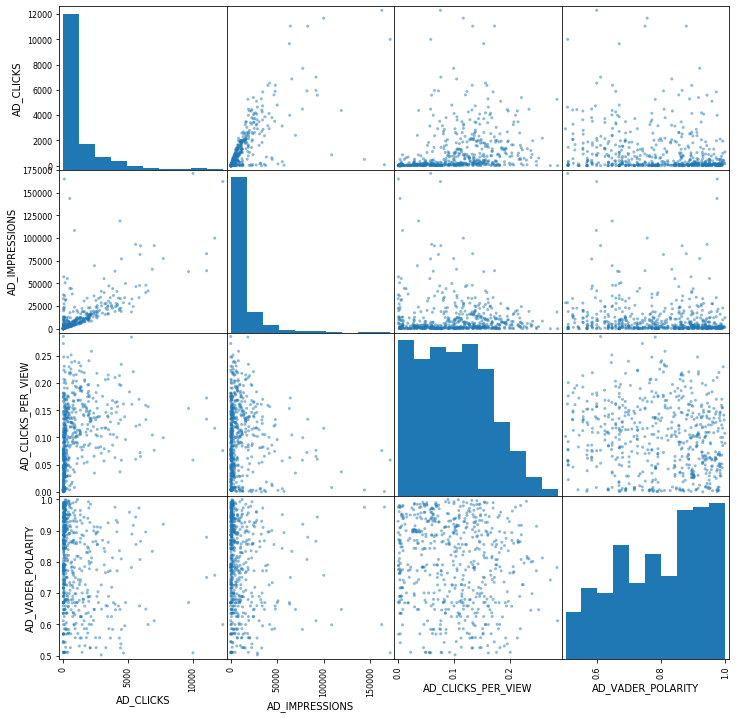

In [38]:
#positive ads corr
scatter_matrix(corrdf[corrdf['AD_VADER_POLARITY'] >= 0.5], figsize=(12, 12))
corrdf[corrdf['AD_VADER_POLARITY'] >= 0.5].corr(method ='spearman') 

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.939358,0.296135,0.059991
AD_IMPRESSIONS,0.939358,1.000000,0.011623,0.079996
AD_CLICKS_PER_VIEW,0.296135,0.011623,1.000000,-0.066699
AD_VADER_POLARITY,0.059991,0.079996,-0.066699,1.000000


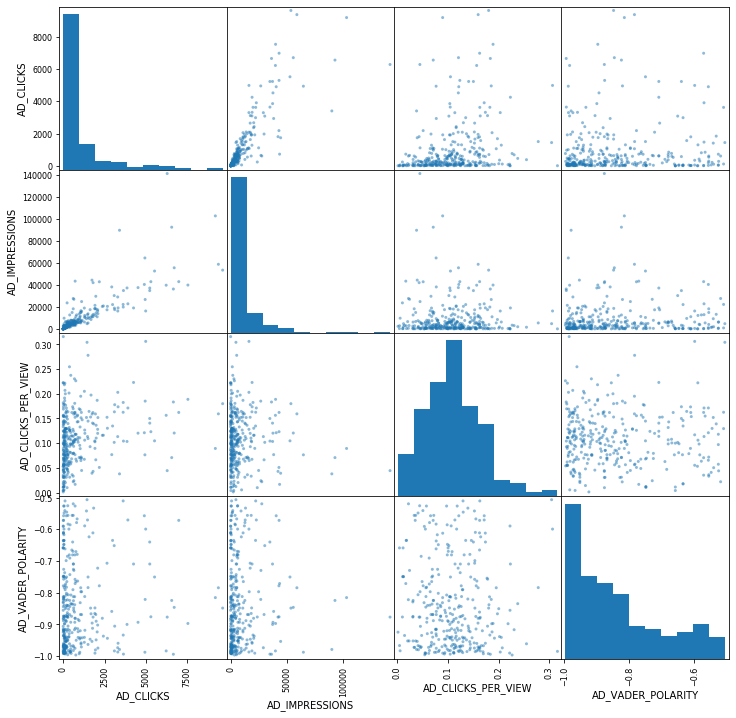

In [39]:
#negative ads corr
scatter_matrix(corrdf[corrdf['AD_VADER_POLARITY'] <= -0.5], figsize=(12, 12))
corrdf[corrdf['AD_VADER_POLARITY'] <= -0.5].corr(method ='spearman') 

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.898294,0.426308,0.057634
AD_IMPRESSIONS,0.898294,1.000000,0.103821,0.112257
AD_CLICKS_PER_VIEW,0.426308,0.103821,1.000000,-0.081001
AD_VADER_POLARITY,0.057634,0.112257,-0.081001,1.000000


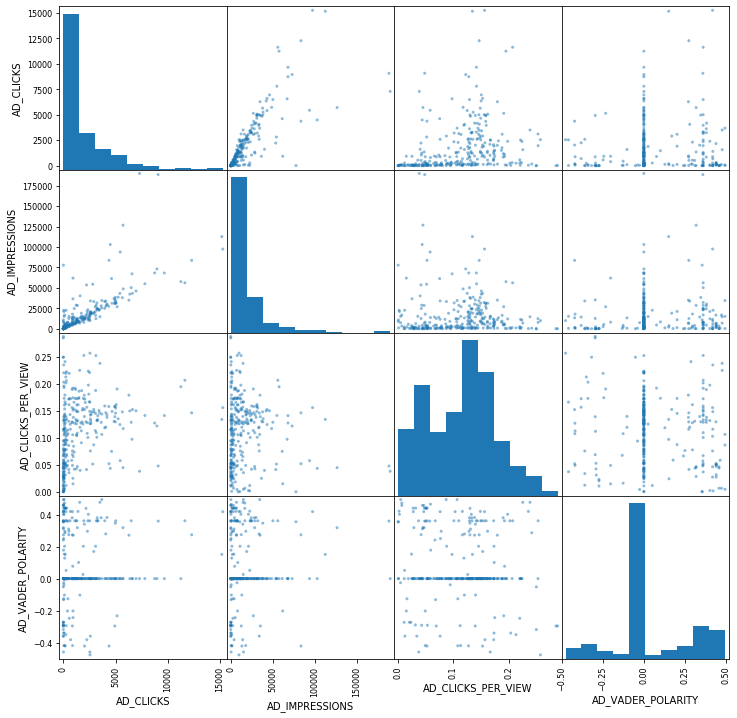

In [40]:
#neutral ads corr
scatter_matrix(corrdf[(corrdf['AD_VADER_POLARITY'] > -0.5) & (corrdf['AD_VADER_POLARITY'] < 0.5)], figsize=(12, 12))
corrdf[(corrdf['AD_VADER_POLARITY'] > -0.5) & (corrdf['AD_VADER_POLARITY'] < 0.5)].corr(method ='spearman') 

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.876759,0.469283,-0.098040
AD_IMPRESSIONS,0.876759,1.000000,0.099396,-0.035576
AD_CLICKS_PER_VIEW,0.469283,0.099396,1.000000,-0.108417
AD_VADER_POLARITY,-0.098040,-0.035576,-0.108417,1.000000


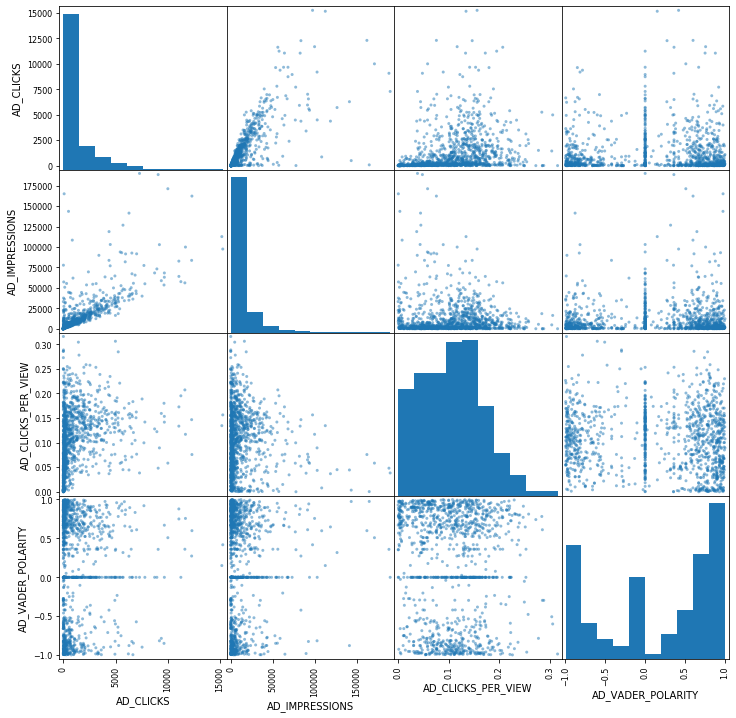

In [41]:
#all ads corr
scatter_matrix(corrdf, figsize=(12, 12))
corrdf.corr(method ='spearman') 

In [42]:
np.corrcoef(corrdf['AD_VADER_POLARITY'],corrdf['AD_CLICKS'])

array([[ 1.        , -0.01160087],
       [-0.01160087,  1.        ]])